In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

import multiprocessing as mp
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

import pyaudio
import wave
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
learning_rate = 0.01
seq_length = 9 #layer
# train Parameters
X_dim = 442 #n_dim #X_hot.shape[2]

#seq_length = 7 #X_hot.shape[1]
output_dim = 1 #n_classes #Y_hot.shape[1]

hidden_dim = 2
learning_rate = 0.05

In [3]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')


# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))

# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def showFreqTime(combine):
    for sample, filename, _ in combine:
        print(sample)
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        print(freqs.min(), freqs.max())
        print(times.min(), times.max())
        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

def printDescription(y_true, y_pred):
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
def makeHot(dataX,seq_length):
    X_hot_list= []
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    return X_hot
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals
def getStream():
    p = pyaudio.PyAudio()
    stream = p.open(format=AUDIO_FORMAT, channels=1, rate=SAMPLE_RATE,
            input=True, frames_per_buffer=CHUNK_SIZE)
    wf = wave.open(WAVE_FILENAME, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(p.get_sample_size(AUDIO_FORMAT))
    wf.setframerate(SR)
    
    t1 = time.time()
    # grab audio and timestamp
    #data = 
    #frames.append(data)
    audio = np.fromstring(stream.read(CHUNK_SIZE), np.int16)
    # write to the audio file
    wf.writeframes(b''.join(audio))
    t2 = time.time()
    print("time: %.4f \t"%(t2-t1),end='')
    
    
    stream.stop_stream()
    stream.close()

    p.terminate()
    return audio.astype(np.float32)


INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


not euqal Sample rate
[-9.61874235e-08 -2.93942436e-05 -1.56517846e-05 ...  2.15513870e-04
  1.64433896e-04  7.93041506e-05]
0.0 22050.0
0.01 0.91
[[0.581947]
 [0.581947]
 [0.581947]
 [0.581947]
 [0.581947]]


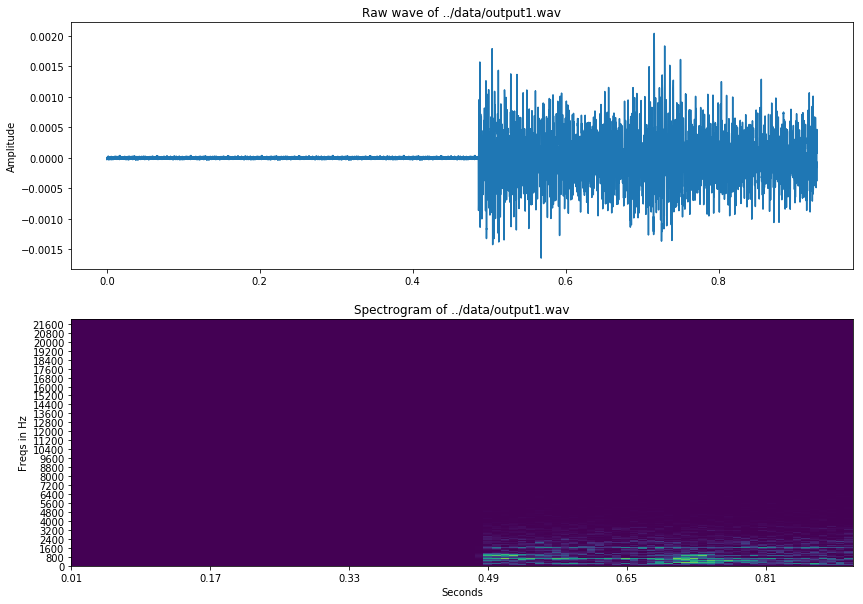

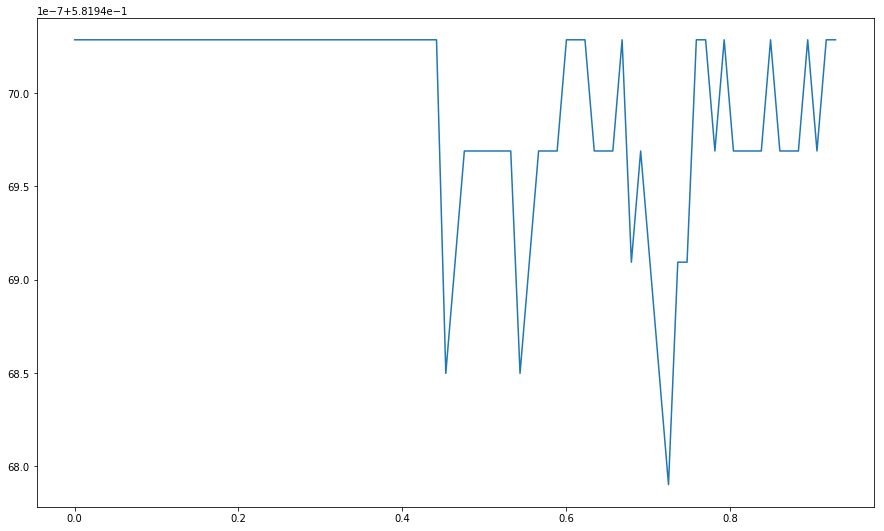

F-Score: 1.0
Accuracy:  1.0
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        83

avg / total       1.00      1.00      1.00        83

[[83]]
The sound is Drone


In [33]:

model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S9_40'

#init 
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, model_path_f+filename)

mean = np.load('../data/Xy/RNN_mean.npy')
std = np.load('../data/Xy/RNN_std.npy')


import time
CHUNK_SIZE = 8192*5*1
AUDIO_FORMAT = pyaudio.paInt16
SR = 44100
SAMPLE_RATE = SR
WAVE_FILENAME = '../data/output1.wav'
####
justone = True
while(justone):
    justone = False
    ###get Data
    #audio = getStream()
    
    ###get Data
    filename1 = '../data/output1.wav'
    audio, sample_rate = librosa.load(filename1)
    
    ###preprocess1 samplerate 맞추기 
    if sample_rate != SR:
        print('not euqal Sample rate')
        new_sample_rate = sample_rate  / (sample_rate/SR)
        audio = signal.resample(audio, int(new_sample_rate/sample_rate * audio.shape[0]))
        sample_rate = new_sample_rate
        
    ###Preprocess2 logspectogram
    freqs, times, spectrogram = log_specgram(audio, SR)  
    showFreqTime([[audio, filename1, SR]])
    
    ###Nomalization
    spectrogram = (spectrogram - mean) / std
    
    ###stacked data
    X_hot = makeHot(spectrogram,seq_length)
    
    ###recognization
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    print(y_pred[:5])
    
    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(1,1,1)
    #ax.set
    ax.plot(np.linspace(0, len(audio)/SR, len(y_pred)), y_pred)
    plt.show()

    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    printDescription(np.ones(shape=[y_pred.shape[0]]), y_pred)
    
    #result
    result = y_pred[-1]
    if result == 1:
        print('The sound is Drone')
    else :
        print('The sound isn\'t Drone')
sess.close() 